In [1]:
from MultKAN import *
from utils import *
from spline import *

In [ ]:
model = KAN(width=[2,5,1], grid=5, k=3, noise_scale=0.3, seed=2)
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2)
model.fit(dataset, opt='LBFGS', steps=20, lamb=0.001);
model.plot()

In [61]:
# current_dir = os.path.dirname(__file__)
import warnings
warnings.filterwarnings("ignore")

def points_to_curve(
    y, 
    x=np.array([1/12, 2/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30]), 
    t=[1, 2, 3, 5], 
    k=3
):
    t = np.r_[(x[0],)*(k+1),
            t,
            (x[-1],)*(k+1)]

    spline = make_lsq_spline(x, y, t, k)
    return spline.c

def treasury_data_retrieval(file_name):
    # file_path = os.path.join(current_dir, '..', 'data', file_name)

    df = pd.read_csv(file_name)
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values(by='Date', ascending=True, inplace=True)
    df = df.reset_index(drop=True)
    df.set_index('Date', inplace=True)

    return df 

def basis_data_retrieval():
    data = treasury_data_retrieval('us_treasury_rates_large.csv')
    basis = data.apply(points_to_curve, axis=1, result_type="expand")
    basis.columns = [f'Basis_{i}' for i in range(basis.shape[1])]
    return basis

def direct_pred_retrieval():
    data = treasury_data_retrieval('us_treasury_rates_large.csv')

    # data = data.set_index('Date')
    targets = data.columns

    # List of moving average windows
    window_list = [1, 3, 5]

    # List of lags to calculate moving average
    lag_list = [1]

    # List of future date values
    shift_list = [_ for _ in range(20)]

    # Generate future columns
    for shift in shift_list:
        for col in targets:
            data[f'{col}_+_{shift}'] = data[col].shift(-shift)

    # Generate past moving average columns
    for lag in lag_list:
        for window in window_list:
            for col in targets:
                data[f'{col}_-_{lag}_window_{window}'] = data[col].shift(1).rolling(window).mean()
    return data, targets

df = direct_pred_retrieval()[0]
df.head()

,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,...,3 Mo_-_1_window_5,6 Mo_-_1_window_5,1 Yr_-_1_window_5,2 Yr_-_1_window_5,3 Yr_-_1_window_5,5 Yr_-_1_window_5,7 Yr_-_1_window_5,10 Yr_-_1_window_5,20 Yr_-_1_window_5,30 Yr_-_1_window_5
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,2.40,2.40,2.42,2.51,2.60,2.50,2.47,2.49,2.56,2.66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,2.42,2.42,2.41,2.47,2.50,2.39,2.35,2.37,2.44,2.56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-04,2.40,2.42,2.42,2.51,2.57,2.50,2.47,2.49,2.56,2.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-07,2.42,2.42,2.45,2.54,2.58,2.53,2.51,2.53,2.60,2.70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-08,2.40,2.42,2.46,2.54,2.60,2.58,2.57,2.58,2.63,2.73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
basis_data_retrieval().head()

,Basis_0,Basis_1,Basis_2,Basis_3,Basis_4,Basis_5,Basis_6,Basis_7
Date,,,,,,,,
2019-01-02,2.389404,2.456850,2.702452,2.471903,2.439430,2.792307,2.836771,2.969621
2019-01-03,2.412773,2.433319,2.566584,2.371960,2.308468,2.708715,2.751877,2.919528
2019-01-04,2.394199,2.477465,2.636133,2.489490,2.430349,2.825259,2.813653,2.979567
2019-01-07,2.404756,2.521129,2.626514,2.525075,2.475281,2.843453,2.857575,2.989649
2019-01-08,2.392421,2.537614,2.632026,2.585591,2.534810,2.833007,2.897892,2.999533


[4.56025102 4.32062331 4.15940159 4.10229804 4.01562962 4.13531236
 4.67780505 4.34010673]


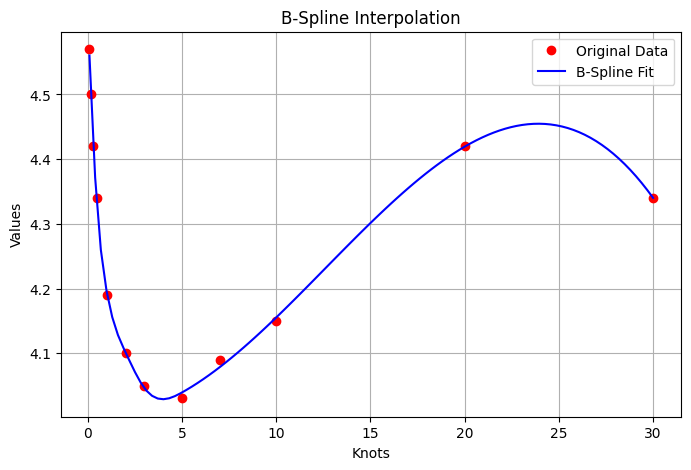

[ 0.08333333  0.16666667  0.25        0.5         1.          2.
  3.          5.          7.         10.         20.         30.        ]
[ 0.08333333  0.08333333  0.08333333  0.08333333  1.          2.
  3.          5.         30.         30.         30.         30.        ]


In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_lsq_spline, BSpline

# Assume `data` is a DataFrame with numerical values
# obj = data.head(1).values.flatten()  # Extract first row as an array
x = np.array([1/12, 2/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30])
y = data.iloc[-1, :].values.flatten()  # Extract first row as an array

# Define knots (assuming `knots` is predefined)
t = [1, 2, 3, 5]
k = 3
t = np.r_[(x[0],)*(k+1),
          t,
          (x[-1],)*(k+1)]
# t = np.r_[(0, 1/24, 1/12, 2/12), t, (15, 20, 25, 30)]
# print(t)

# # Fit B-Spline
spline = make_lsq_spline(x, y, t, k)
print(spline.c)
# print(y)

# if k > 0 and np.any((x < t[k]) | (x > t[-k])): > 1643     raise ValueError('Out of bounds w/ x = %s.' % x)
# Generate smooth values for plotting
x_fine = np.linspace(min(x), max(x), 100)
y_fine = spline(knots_fine)  # Evaluate B-spline

# Plot the interpolation
plt.figure(figsize=(8, 5))
plt.plot(x, y, 'ro', label='Original Data')  # Original points
plt.plot(x_fine, y_fine, 'b-', label='B-Spline Fit')  # B-Spline curve
plt.xlabel('Knots')
plt.ylabel('Values')
plt.title('B-Spline Interpolation')
plt.legend()
plt.grid(True)
plt.show()
print(x)
print(t)


In [45]:
def points_to_curve(
    y, 
    x=np.array([1/12, 2/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30]), 
    t=[1, 2, 3, 5], 
    k=3
):
    t = np.r_[(x[0],)*(k+1),
            t,
            (x[-1],)*(k+1)]

    spline = make_lsq_spline(x, y, t, k)
    return spline.c

points_to_curve(y)

array([4.56025102, 4.32062331, 4.15940159, 4.10229804, 4.01562962,
       4.13531236, 4.67780505, 4.34010673])